usando uma imagem de tamanho menor:
 407 x 540

Dataset maior 30k 

In [ ]:
#
#  ambiente..
#
# ref https://colab.research.google.com/drive/151805XTDg--dgHb3-AXJCpnWaqRhop_2#scrollTo=qvyB0VG4j4zx

#GPU count and name
!nvidia-smi -L

#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi
!lscpu |grep 'Model name'

#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

!lscpu | grep "L3 cache" 

#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"

#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'

#hard disk space that we can use
!df -h / | awk '{print $4}'


GPU 0: Tesla T4 (UUID: GPU-b4609bd1-0ecc-06b1-b454-6bd0bd6f4877)
Fri Jan 22 15:02:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                       

In [ ]:
#
# mount and unzip
#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#
# initialize...
#
checkdir_pre= "v141/try13-ds034-v4/1003"
checkdir    = "v141/try13-ds034-v4/1005"

NO_TEACH= True
FREEZE_ENCODER= False
TRAIN_LENGTH= 16
BATCH_SIZE = 32
EMBEDDING_DIM = 256
UNITS = 512
LEARNING_RATE=0.0005
# NUM_OF_WORDS= 220
SAMPLED= True
# VOCAB_SIZE= NUM_OF_WORDS+1 
SAVE_IF_BETTER_THAN_LOSS= 0.0   #dont save
_best_loss= 10  # best loss until now


In [ ]:
#
# Ref=> https://www.tensorflow.org/tutorials/text/image_captioning
# https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2
#
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np  
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import cv2
from sklearn.utils import shuffle
from google.colab import drive
from pathlib import Path
import random
print(tf.__version__) 

Found GPU at: /device:GPU:0
2.4.0


In [ ]:
# !unzip -q '/content/drive/My Drive/mestrado/public/datasets/v6-labels-only.zip'

In [ ]:
!unzip -q '/content/drive/My Drive/mestrado/public/datasets/dataset-v035--2lines-32k-v5.0.zip'

In [ ]:
# 
# unzipN

#
!unzip -q '/content/drive/My Drive/mestrado/public/datasets/new-random-8lines--v1--test-only-2lines.zip'

In [ ]:
# !unzip -q '/content/drive/My Drive/mestrado/public/datasets/unified/unified-all-labels-noponct.zip'

In [ ]:
#
# basics
#
tstart= time.time()
def print_time():
  end = time.time()
  hours, rem = divmod(end-tstart, 3600)
  minutes, seconds = divmod(rem, 60)
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

print_time()

def read_label( path):
  f= open( path)
  d= f.read()
  f.close()
  return d 

def show_image( img, name= 'noname'):
  plt.imshow( img)
  plt.title( name)
  plt.show()

00:00:00.00


In [ ]:
#
# tokenizer
#
def build_tokenizer():
  with open('/content/new-random-8lines--v1--test-only-2lines/all-labels-shuffle.pgn') as file:
    labels = [line.strip() for line in file]
  labels= ['<start> ' + label + ' <end>' for label in labels]

  # Choose the top 5000 words from the vocabulary
  print( 'building...')
  top_k = 5000   # para ajustar ao modelo antigo...
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                    lower=False,
                                                    oov_token="<unk>",
                                                    filters= ' ')
                                                    # filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

  #forca a usar sempre uma lista com todas as words com 1 ocorrecia de cada word
  tokenizer.fit_on_texts(labels)
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'
  return tokenizer

# NEW tokenizer
tokenizer= build_tokenizer()
print( 'total do vocabularario= ', len(tokenizer.word_index))    # expected 1578
# print( 'considerados no encoding= ', NUM_OF_WORDS)

VOCAB_SIZE= len(tokenizer.word_index)+1 
print( 'VOCAB_SIZE', VOCAB_SIZE)

building...
total do vocabularario=  179
VOCAB_SIZE 180


In [ ]:
#
# load images and labels
#
# def cleanup(line):
#     return re.sub('[^0-9a-zA-Z -]+', '', line).replace( 'x', '')

def load_data_from( path):
	image_files= glob( os.path.join( path, 'images/*.jpg'))
	image_files.sort()

	label_files= glob( os.path.join( path, 'labels/*.pgn'))
	label_files.sort()
	labels= [read_label( f) for f in label_files]
	# labels= [cleanup( x).lower() for x in labels]
	labels= ['<start> ' + label + ' <end>' for label in labels]

	# poderia ser menor... mas pega os primeiros 10. Nem precisava restringir...
	labels= [label.split()[0:16+1] for label in labels]

	# somente uma parte por enquanto
	if SAMPLED:
		n= int( len( image_files)*0.80)
		combined= list( zip( image_files, labels))
		random.Random(0).shuffle(combined)
		image_files[:], labels[:]= zip( *combined[:n])
		print( "SAMPLED!!  size= ", len( image_files), len( labels))

	label_indexes = tokenizer.texts_to_sequences(labels)
	for i in range( 0, 3):
		print( labels[i], '=>', label_indexes[i])
 
	return image_files, label_indexes, labels

#shuffle
# train_img_names, train_label_indexes, train_label_words= load_data_from( '/content/shuffle_8lines_32K/train')
# valid_img_names, valid_label_indexes, valid_label_words= load_data_from( '/content/shuffle_8lines_32K/valid')

#final
train_img_names, train_label_indexes, train_label_words= load_data_from( '/content/dataset-v035--2lines-32k-v5.0/train')
valid_img_names, valid_label_indexes, valid_label_words= load_data_from( '/content/dataset-v035--2lines-32k-v5.0/valid')

SAMPLED!!  size=  21428 21428
['<start>', 'e4', 'e5', 'Nf3', 'Nc6', '<end>'] => [2, 3, 109, 71, 57, 178]
['<start>', 'e4', 'c5', 'Nf3', 'e6', '<end>'] => [2, 3, 6, 71, 96, 178]
['<start>', 'e4', 'e5', 'Nf3', 'Nc6', '<end>'] => [2, 3, 109, 71, 57, 178]
SAMPLED!!  size=  5281 5281
['<start>', 'Bb3', 'dxc5', 'Nbd7', 'Bxd7+', '<end>'] => [2, 64, 38, 68, 88, 178]
['<start>', 'exd5', 'Na6', 'Nc2', 'dxc5', '<end>'] => [2, 17, 36, 94, 38, 178]
['<start>', 'e4', 'c5', 'd3', 'Nc6', '<end>'] => [2, 3, 6, 37, 57, 178]


In [ ]:
#
# PREPROCESSAMENTO...
#

In [ ]:
#
# carrega VGG19
#
image_model = tf.keras.applications.VGG16(include_top=False,
                                                weights='imagenet',
                                                input_shape= (200, 862, 3))  # => gera (16, 19, 2048)
                                                # input_shape= (900, 678, 3))  # => gera (16, 19, 2048)
                                                # O input shape nao é obrigatorio, mas setando dá para
                                                # ver o tamanho do output
new_input = image_model.input
hidden_layer = image_model.layers[-2].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
print( image_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 862, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 862, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 862, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 431, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 431, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 431, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 215, 128)      0     

In [ ]:
# -1 gera (None, 18, 21, 512)
ATTENTION_SHAPE= (12,53) #(28,21)
FEATURES_SHAPE = 512
ATTENTION_FEATURES_SHAPE = ATTENTION_SHAPE[0]*ATTENTION_SHAPE[1]  #16*19   # 308

In [ ]:
#
# build cache por preprocessed images
#
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (200, 862)) #(450, 339))  #original=(576, 678, 3)
    # img = tf.image.resize(img, (540, 407)) #(450, 339))  #original=(576, 678, 3)
    # img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img, image_path
	
def build_cache_for( img_name_vector):
  encode_train = sorted(set(img_name_vector))

  # Feel free to change batch_size according to your system configuration
  image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
  image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(8) #(16)

  for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
      path_of_feature = p.numpy().decode("utf-8")
      np.save(path_of_feature, bf.numpy())
	  
	  
build_cache_for( train_img_names)
build_cache_for( valid_img_names)

In [ ]:
#
# build dataset
#

In [ ]:
# Load the numpy files
BUFFER_SIZE = 1000
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap
  

def build_dataset( img_names, label_indexes):
  # deixa no mesmo tamanho, maximo 32
  label_indexes= [label[:32] for label in label_indexes]
  label_indexes= tf.keras.preprocessing.sequence.pad_sequences(label_indexes, padding='post')

  dataset = tf.data.Dataset.from_tensor_slices((img_names, label_indexes))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE, seed= 0).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

  
train_dataset= build_dataset( train_img_names, train_label_indexes)
valid_dataset= build_dataset( valid_img_names, valid_label_indexes)

train_num_steps= len( train_img_names)//BATCH_SIZE
valid_num_steps= len( valid_img_names)//BATCH_SIZE

In [ ]:
#
# Model
#

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    # print( 'BahdanauAttention.features =>', features.shape) #(64, 64, 256), segundo 64=length(encoder_output)
    # print( 'BahdanauAttention.hidden =>', hidden.shape) #(64, 512)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # print( 'BahdanauAttention.hidden_with_time_axis =>', hidden_with_time_axis.shape) #(64, 1, 512)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) 
    # print( 'BahdanauAttention.score =>', score.shape)   #(64, 64, 512)

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # print( 'BahdanauAttention.attention_weights =>', attention_weights.shape)  #(64, 64, 1) segundo 64 vem do tamanho da sequencia apos cnn

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    # print( 'BahdanauAttention.context_vector =>', context_vector.shape)  #(64, 64, 256) segundo 64= length(encoder_output)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # print( 'BahdanauAttention.context_vector =>', context_vector.shape) #(64, 256)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):

    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim, units):
        super(CNN_Encoder, self).__init__()
        self.units = units
        # shape after fc == (batch_size, 64, embedding_dim)
        # self.gru1= tf.keras.layers.GRU(self.units,
                                  #      dropout= ENCODER_DROPOUT,
                                  #  return_sequences=True) 
        self.bgru= tf.keras.layers.Bidirectional( tf.keras.layers.GRU(self.units,
                                       dropout= 0.2,
                                   return_sequences=True)) 
        self.drop= tf.keras.layers.Dropout( 0.2)
        # self.gru= tf.keras.layers.GRU(self.units,
        #                            return_sequences=True)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.bgru( x)
        # x = self.bgru2( x)
        x = self.drop(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU( self.units,
                                   dropout= 0.2,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # self.gru.trainable= False
    self.fc1 = tf.keras.layers.Dense(self.units)    #512
    # self.fc2 = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.0001))    #256
    self.fcF = tf.keras.layers.Dense(vocab_size)    # 120

    # self.bn0 = tf.keras.layers.BatchNormalization()
    # self.bn1 = tf.keras.layers.BatchNormalization()
    # self.bn2 = tf.keras.layers.BatchNormalization()

    # self.drop0= tf.keras.layers.Dropout( 0.7)
    self.drop= tf.keras.layers.Dropout( 0.2)
    # self.drop2= tf.keras.layers.Dropout( 0.7)

    # self.dropout = tf.keras.layers.Dropout(0.5)
    # self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, 
    #                     center=True, scale=True, beta_initializer='zeros', 
    #                     gamma_initializer='ones', moving_mean_initializer='zeros', 
    #                     moving_variance_initializer='ones', beta_regularizer=None, 
    #                     gamma_regularizer=None, beta_constraint=None, 
    #                     gamma_constraint=None)

    self.attention = BahdanauAttention(self.units)
    if FREEZE_ENCODER:
      self.attention.trainable = False

  def freeze_attention(self):
      self.attention.trainable = False

  def call(self, x, features, hidden):
    # print( 'decoder.call=> ', x.shape, features.shape, hidden.shape) #(64, 1) (64, 64, 256) (64, 512)

    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)
    # print( 'decoder.attention=> ', context_vector.shape, attention_weights.shape) #(64, 256) (64, 64, 1)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # print( 'decoder.embedding=> ', x.shape) #(64, 1, 256)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # print( 'decoder.concat=> ', x.shape) #(64, 1, 512)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # output = self.bn0(output)
    # output = self.drop0(output)

    x = self.fc1(output)    #fc1= Dense( 512)
    # x= output
    # x = self.bn1(x)
    x = self.drop(x)

    x = tf.reshape(x, (-1, x.shape[2])) 
    # x = self.fc2(x) # 256
    # x = self.bn2(x)
    # x = self.drop2(x)

    # x= self.dropout(x)
    # x= self.batchnormalization(x)
    x = self.fcF(x) #fc2= Dense(5000)
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
# 
# build the model
#

In [ ]:
encoder = CNN_Encoder(EMBEDDING_DIM, UNITS)
if FREEZE_ENCODER:
  encoder.trainable = False

decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  # print( 'loss_function.real, pred', real.shape, pred.shape)  #(64,) (64, 5001)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
#
# checkpoint manager
#

In [ ]:
def build_and_recover_checkpoint( checkdir_pre, checkdir):
  ckpt = tf.train.Checkpoint(encoder=encoder,
                              decoder=decoder,
                              optimizer = optimizer)
                              
  checkpoint_path = "/content/drive/My Drive/mestrado/"+checkdir+"/checkpoints/train"
  ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

  epoch = 0
  if ckpt_manager.latest_checkpoint:
    print( "restoring from current "+ ckpt_manager.latest_checkpoint)
    epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print( '_epoch= ', epoch)
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)
  elif not checkdir_pre is None:
    checkpoint_pre_path = "/content/drive/My Drive/mestrado/"+checkdir_pre+"/checkpoints/train"
    lastest_pre= tf.train.latest_checkpoint(checkpoint_pre_path)
    if lastest_pre:
      print( "restore from pretraining  "+ lastest_pre, '...')
      ckpt.restore( tf.train.latest_checkpoint(checkpoint_pre_path))
  else:
      pass
  return ckpt_manager, ckpt, epoch

def restore_checkpoint_to_last():
  if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print( 'restored!', ckpt_manager.latest_checkpoint)
  else:
    print( 'no checkpoint found!!')

ckpt_manager, ckpt, _epoch= build_and_recover_checkpoint( checkdir_pre, checkdir)

restore from pretraining  /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1003/checkpoints/train/ckpt-32 ...


In [ ]:
#
# training
#

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

def reset_metric_plot():
  global loss_plot_train, loss_plot_valid, acc_plot_train, acc_plot_valid
  loss_plot_train = []
  loss_plot_valid = []
  acc_plot_train = []
  acc_plot_valid = []
reset_metric_plot()

def plot_metrics():
  plt.plot(loss_plot_train)
  plt.plot(loss_plot_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Plot')
  plt.gca().legend(('train loss','validation loss'))
  plt.show()

  plt.plot(acc_plot_train)
  plt.plot(acc_plot_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.title('Acc Plot')
  plt.gca().legend(('train acc','validation acc'))
  plt.show()  

In [ ]:
@tf.function
def train_step(img_tensor, target, train_length):
  loss = 0
  zeros= np.zeros(target.shape[0]).astype(int)

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims(
      zeros if NO_TEACH else [tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)

    for i in range(1, train_length+1): 
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      # tf.keras.backend.print_tensor( predictions)
      # tf.keras.backend.print_tensor( tf.reduce_max( predictions))
      # tf.keras.backend.print_tensor( tf.reduce_min( predictions))

      loss += loss_function(target[:, i], predictions)
      train_acc_metric.update_state(target[:, i], predictions)

      dec_input = tf.expand_dims(zeros if NO_TEACH else target[:, i], 1)

  total_loss = (loss / int(train_length))

  # update model
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
def call_train_step_for_debug():
  batch, (img_tensor, target)= next( enumerate(train_dataset))
  batch_loss, t_loss = train_step(img_tensor[0:1], target[0:1], 4)
  print( 'loss= ', batch_loss.numpy())

# call_train_step_for_debug()

In [ ]:
#
# call train without update the gradient
#
@tf.function
def test_step(img_tensor, target, train_length):
  loss = 0
  zeros= np.zeros(target.shape[0]).astype(int)

  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims(
      zeros if NO_TEACH else [tokenizer.word_index['<start>']] * target.shape[0], 1)
  features = encoder(img_tensor)

  for i in range(1, train_length+1):
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      loss += loss_function(target[:, i], predictions)
      valid_acc_metric.update_state(target[:, i], predictions)

      dec_input = tf.expand_dims(zeros if NO_TEACH else target[:, i], 1)

  total_loss = (loss / int(train_length))
  return loss, total_loss


In [ ]:
def train_more( loss_target, train_length, val_loss_limit): #, n_epoch):
  global _epoch
  global _best_loss

  MAX_EPOCH=200 

  print( "-- loss_target=>", loss_target, " train_length=", train_length)
  for _ in range(0,MAX_EPOCH):
      _epoch+= 1
      start = time.time()
      total_loss = 0
      
      train_acc_metric.reset_states()
      valid_acc_metric.reset_states()

      #
      # training loop
      #
      for (batch, (img_tensor, target)) in enumerate(train_dataset):
          batch_loss, t_loss = train_step(img_tensor, target, train_length)
          total_loss += t_loss

          if batch % 50 == 0:
              print ('Epoch {} Batch {} Loss {:.4f}'.format(
                _epoch, batch, batch_loss.numpy() / train_length))

      train_loss= total_loss/train_num_steps
      loss_plot_train.append(train_loss)
      train_acc = float(train_acc_metric.result())
      acc_plot_train.append(train_acc)

      #
      # validation loop
      #
      valid_total_loss = 0
      for (batch, (img_tensor, target)) in enumerate(valid_dataset):
          batch_loss, t_loss = test_step(img_tensor, target, train_length)
          valid_total_loss += t_loss
      valid_loss= valid_total_loss / valid_num_steps
      loss_plot_valid.append(valid_loss)
      valid_acc = float(valid_acc_metric.result())
      acc_plot_valid.append(valid_acc)

      #
      # print..
      #

      print ('Epoch {} Loss {:.6f}  acc: {:.4f} [ Validation Loss {:.6f} valid_acc: {:.4f} ]'.format(
                                  _epoch,
                                  train_loss, 
                                  train_acc,
                                  valid_loss, 
                                  valid_acc))
      print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
      print_time()    


      # 
      # target reached?
      #
      if loss_target> 0 and (train_loss)<= loss_target:
        print( "Target reached! stop!", ' len= ', train_length)

        ckpt_manager.save()  
        print( 'saved checkpoint!', ckpt_manager.latest_checkpoint)
        plot_metrics()
        return True

      if train_loss< _best_loss:
        _best_loss= train_loss
        print( 'New record! _best_loss= ', _best_loss)
        if train_loss< SAVE_IF_BETTER_THAN_LOSS :
            ckpt_manager.save()  
            print( 'saved checkpoint!', ckpt_manager.latest_checkpoint)

      # se validacao estoura significa que esta desaprendendo attention, portanto faz abort
      # TODO: Como implementar early stop?
      if valid_loss>= val_loss_limit:   
        print( "Oops, desaprendendo. Aborta sem salvar!")
        return False

  print( 'epoch exceeded')
  return False
    

In [ ]:
MAX_RETRY= 0
def train_more_with_retry( loss_target, _length, valid_loss_limit):
  retry_count= 0
  while True:
    print( 'len=', _length, ' try_count=', retry_count)
    ok= train_more( loss_target, _length, valid_loss_limit)
    if ok: 
      return True

    if retry_count>= MAX_RETRY:
      print( 'givup!')
      return False
    retry_count+= 1

    #volta para inicio da iteracao anterior
    restore_checkpoint_to_last()
  return False


In [ ]:
def evaluate(image, _length, no_teach= True):
    # print( 'evaluate>>')
    # print( "_length", _length)

    attention_plot = np.zeros((32, ATTENTION_FEATURES_SHAPE))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([0 if no_teach else tokenizer.word_index['<start>']], 0)
    result = []
    # result_top5 = []

    for i in range(_length): 
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id] if predicted_id< len( tokenizer.index_word) else "OUT")

        # predicted_id_top5= tf.math.top_k( predictions, 10)[1][0].numpy()
        # result_top5.append( [tokenizer.index_word[id] for id in predicted_id_top5])
        dec_input = tf.expand_dims([0 if no_teach else predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, None

In [ ]:
def plot_attention(image, result, attention_plot, expected= None):
  print( image)
  temp_image = np.array(Image.open(image))

  fig = plt.figure(figsize=(50, 50))

  len_result = len(result)
  for l in range(len_result):
    temp_att = np.resize(attention_plot[l], ATTENTION_SHAPE) 
    ax = fig.add_subplot(8, 9, l+1)
    if expected is None or l>= len( expected):
      ax.set_title(result[l], fontsize= 40)
    else:
      ax.set_title(result[l]+" ("+expected[l]+")", fontsize= 40)
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()


In [ ]:
def evaluate_random_from_dataset( image_path, label_words, train_length):
  result, attention_plot, _ = evaluate(image_path, train_length)

  # TODO: Pode estar errado...
  m = tf.keras.metrics.Accuracy()
  m.update_state( 
          tokenizer.texts_to_sequences(label_words)[1:train_length+1],
          tokenizer.texts_to_sequences(result)[0:train_length])
          # [tokenizer.word_index[w] for w in label_words][1:train_length+1], 
          # [tokenizer.word_index[w] for w in result][0:train_length])

  # print( 'accurary', float( m.result()))
  print ('expected=', label_words[1:])
  print ('predicted=', result)
  plot_attention(image_path, result, attention_plot, label_words[1:])

def evaluate_train( n, train_length):
  for i in range(0, n):
    evaluate_random_from_dataset( train_img_names[i], train_label_words[i], train_length) 

def evaluate_valid( n, train_length):
  for i in range(0, n):
    evaluate_random_from_dataset( valid_img_names[i], valid_label_words[i], train_length) 

#evaluate_train(1, 32)

In [ ]:
def evaluate_full_valid_dataset(_length):
    total_loss = 0
    valid_acc_metric.reset_states()
    for (batch, (img_tensor, target)) in enumerate(valid_dataset):
        batch_loss, t_loss = test_step(img_tensor, target, _length)
        total_loss += t_loss

    valid_loss= total_loss / valid_num_steps
    valid_acc = float(valid_acc_metric.result())
    print ('len {} Validation Loss {:.6f} valid_acc: {:.4f} ]'.format(
                        _length,
                        valid_loss, 
                        valid_acc))


In [ ]:
#
# Adicionais para teste da acuracia do test set
#

In [ ]:
import nltk
from nltk.metrics import distance

def cir_word( hp, gt):
    return distance.edit_distance(hp, gt)/len( gt)
	
def cir_line( expected, predicted):
    return tf.reduce_mean( [cir_word(e, p) for (e, p) in zip( expected, predicted)]).numpy()

def cir_set( labels, result, _len= None):
    if _len is None:
      _len= len( labels)
    return tf.reduce_mean( [cir_line(e[:_len], p[:_len]) for (e, p) in zip( labels, result)]).numpy()


In [ ]:
def load_from_path( path, max= None):
  test_images= glob( os.path.join( path, 'images/*.jpg'))
  test_images.sort()

  test_labels_files= glob( os.path.join( path, 'labels/*.pgn'))
  test_labels_files.sort()
  test_labels= [read_label( f) for f in test_labels_files]
  # test_labels= [cleanup( x).lower() for x in test_labels]
  test_labels= [label.split() for label in test_labels]
  if max is None:
    return test_images, test_labels
  else:
    return test_images[:max], test_labels[:max]

def load_test():
  return load_from_path( '/content/new-random-8lines--v1--test-only-2lines/test') 

def load_test_2():
  return load_from_path( '/content/new-random-8lines--v1--test-only-2lines/test--v2') 
  
def evaluate_all_data(images,labels,maxlen,no_teach=True):
  result_ac= []
  print( 'EVALUATING ALL DATA',len( images))
  # treina todos
  result= []
  # best= { "score": None }
  # worst= { "score": None }
  for i in range(0,len( images)):
    if( i%100== 0):
      print( 'evaluating ', i, '...')
    r, attention_plot, _ = evaluate(images[i], maxlen, no_teach)
    result.append( r)

    # habilitar para exibir resultado e esperado
    if i< 5:
      print( '------------------------', i, '------------------------------')
      print( 'predicted', r)
      print( 'expected', labels[i])

      #habilitar para plotar attention
      plot_attention(images[i], r, attention_plot, labels[i])

  # calcula a acuracia para cada tamanho
  for _len in range(1,maxlen+1):
    m = tf.keras.metrics.Accuracy()

    # acuracia para cada teste, até o tamanho atual
    for i in range( 0, len( result)):
      uselen= min( len( labels[i]), len( result[i]), _len)
      m.update_state( 
              tokenizer.texts_to_sequences(labels[i])[:uselen],
              tokenizer.texts_to_sequences(result[i])[:uselen])
              # [tokenizer.word_index[w] if w in tokenizer.word_index else 0 for w in labels[i]][:uselen], 
              # [tokenizer.word_index[w] if w in tokenizer.word_index else 0  for w in result[i]][:uselen])
    
    print( 'len', _len, 'accuracy', float( m.result()), 'cir', cir_set( labels, result, _len))
    result_ac.append( float( m.result()))

  return result_ac

def plot_accuracy( checkpoint, result_acc):
  plt.xlabel('sequence length')
  plt.ylabel('accuracy')
  for r, check_name in result_acc:
    plt.plot(r)
  plt.title('checkpoint: '+ checkpoint)
  plt.gca().legend([check_name for _, check_name in result_acc])
  plt.show()
  
def make_evaluations_test_set(_len):
  # for check_dir, no_teach in checkpoints:
    # print( 'checkpoint', check_dir)
    # restore_from( check_dir)
  result_acc= []
  result_acc.append( (evaluate_all_data(*load_test(), _len), 'test'))
  # result_acc.append( (evaluate_all_data(*load_test_2(), _len), 'test--v2'))
  plot_accuracy( checkdir, result_acc)

# make_evaluations_test_set(1)

In [ ]:
#
# training loop, attention
#

iniciando para lengh 1  target 0.25
len= 1  try_count= 0
-- loss_target=> 0.25  train_length= 1
Epoch 1 Batch 0 Loss 0.0658
Epoch 1 Batch 50 Loss 0.5191
Epoch 1 Batch 100 Loss 0.6028
Epoch 1 Batch 150 Loss 0.5048
Epoch 1 Batch 200 Loss 0.3509
Epoch 1 Batch 250 Loss 0.0610
Epoch 1 Batch 300 Loss 0.2429
Epoch 1 Batch 350 Loss 0.0327
Epoch 1 Batch 400 Loss 0.8275
Epoch 1 Batch 450 Loss 0.1116
Epoch 1 Batch 500 Loss 0.0406
Epoch 1 Batch 550 Loss 0.0138
Epoch 1 Batch 600 Loss 0.0544
Epoch 1 Batch 650 Loss 0.3363
Epoch 1 Loss 0.214889  acc: 0.9423 [ Validation Loss 0.137827 valid_acc: 0.9555 ]
Time taken for 1 epoch 1202.1855034828186 sec

00:35:21.03
Target reached! stop!  len=  1
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1005/checkpoints/train/ckpt-33


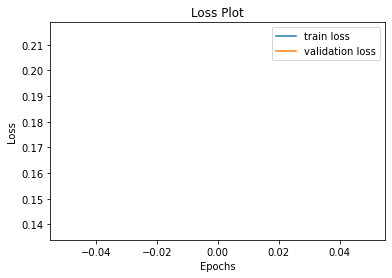

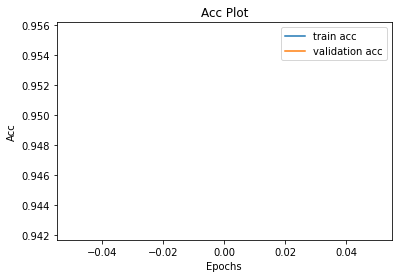

00:35:21.79
expected= ['e4', 'e5', 'Nf3', 'Nc6', '<end>']
predicted= ['e4']
/content/dataset-v035--2lines-32k-v5.0/train/images/e4__e5__Nf3_Nc6_0868_4120_L_part5_scan0064.jpg


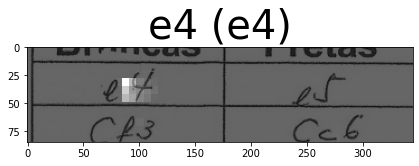

expected= ['Bb3', 'dxc5', 'Nbd7', 'Bxd7+', '<end>']
predicted= ['Bb3']
/content/dataset-v035--2lines-32k-v5.0/valid/images/new-random_2f95295e.jpg


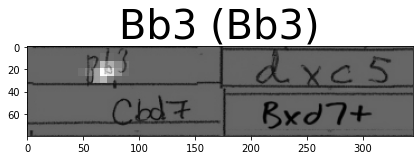

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


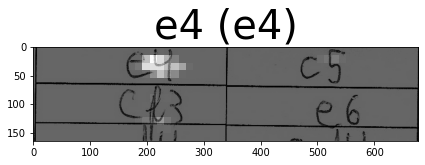

------------------------ 1 ------------------------------
predicted ['e4']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


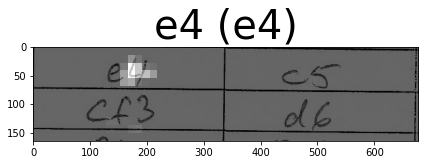

------------------------ 2 ------------------------------
predicted ['Nf3']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


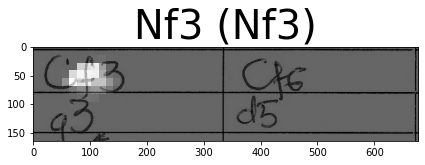

------------------------ 3 ------------------------------
predicted ['c4']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


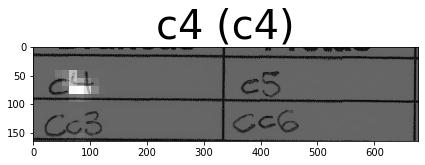

------------------------ 4 ------------------------------
predicted ['d4']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


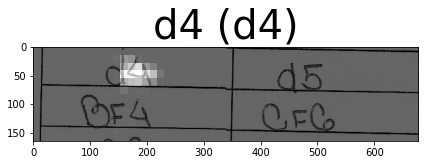

evaluating  100 ...
len 1 accuracy 0.8333333134651184 cir 0.086257316


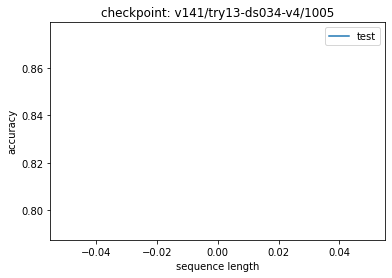

iniciando para lengh 1  target 0.1
len= 1  try_count= 0
-- loss_target=> 0.1  train_length= 1
Epoch 2 Batch 0 Loss 0.0550
Epoch 2 Batch 50 Loss 0.2482
Epoch 2 Batch 100 Loss 0.0048
Epoch 2 Batch 150 Loss 0.0114
Epoch 2 Batch 200 Loss 0.0079
Epoch 2 Batch 250 Loss 0.0033
Epoch 2 Batch 300 Loss 0.0093
Epoch 2 Batch 350 Loss 0.1090
Epoch 2 Batch 400 Loss 0.0074
Epoch 2 Batch 450 Loss 0.0050
Epoch 2 Batch 500 Loss 0.0695
Epoch 2 Batch 550 Loss 0.0318
Epoch 2 Batch 600 Loss 0.0066
Epoch 2 Batch 650 Loss 0.0164
Epoch 2 Loss 0.054775  acc: 0.9836 [ Validation Loss 0.127271 valid_acc: 0.9600 ]
Time taken for 1 epoch 1198.8687522411346 sec

00:58:30.13
Target reached! stop!  len=  1
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1005/checkpoints/train/ckpt-34


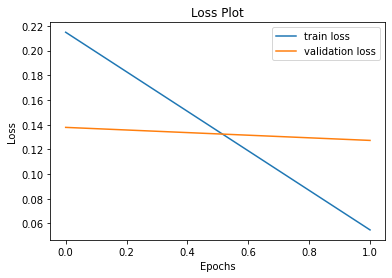

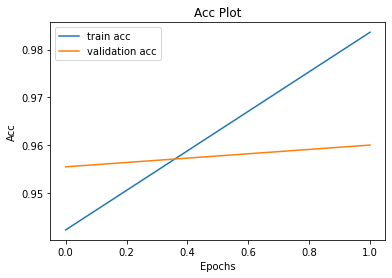

00:58:30.77
expected= ['e4', 'e5', 'Nf3', 'Nc6', '<end>']
predicted= ['e4']
/content/dataset-v035--2lines-32k-v5.0/train/images/e4__e5__Nf3_Nc6_0868_4120_L_part5_scan0064.jpg


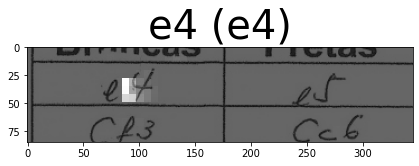

expected= ['Bb3', 'dxc5', 'Nbd7', 'Bxd7+', '<end>']
predicted= ['Bb3']
/content/dataset-v035--2lines-32k-v5.0/valid/images/new-random_2f95295e.jpg


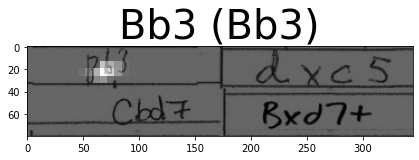

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


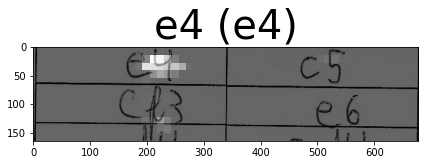

------------------------ 1 ------------------------------
predicted ['e4']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


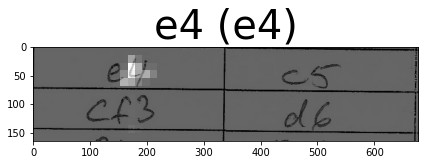

------------------------ 2 ------------------------------
predicted ['Nf3']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


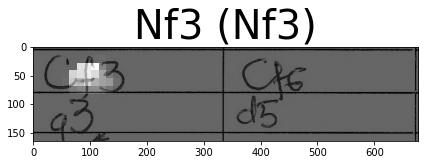

------------------------ 3 ------------------------------
predicted ['c4']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


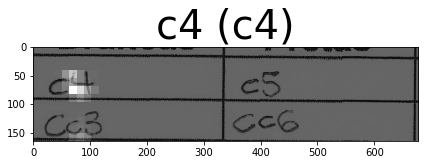

------------------------ 4 ------------------------------
predicted ['d4']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


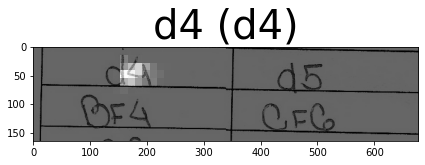

evaluating  100 ...
len 1 accuracy 0.8684210777282715 cir 0.07017544


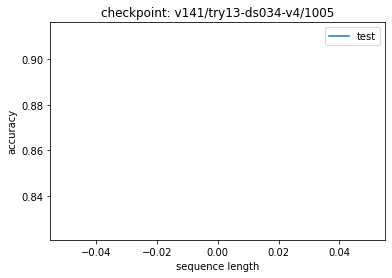

iniciando para lengh 2  target 0.25
len= 2  try_count= 0
-- loss_target=> 0.25  train_length= 2
Epoch 3 Batch 0 Loss 0.2424
Epoch 3 Batch 50 Loss 0.1660
Epoch 3 Batch 100 Loss 0.0373
Epoch 3 Batch 150 Loss 0.0570
Epoch 3 Batch 200 Loss 0.0550
Epoch 3 Batch 250 Loss 0.1084
Epoch 3 Batch 300 Loss 0.1258
Epoch 3 Batch 350 Loss 0.0696
Epoch 3 Batch 400 Loss 0.1616
Epoch 3 Batch 450 Loss 0.1181
Epoch 3 Batch 500 Loss 0.0666
Epoch 3 Batch 550 Loss 0.0072
Epoch 3 Batch 600 Loss 0.0472
Epoch 3 Batch 650 Loss 0.1994
Epoch 3 Loss 0.123282  acc: 0.9636 [ Validation Loss 0.160398 valid_acc: 0.9535 ]
Time taken for 1 epoch 1211.109528541565 sec

01:21:50.47
Target reached! stop!  len=  2
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1005/checkpoints/train/ckpt-35


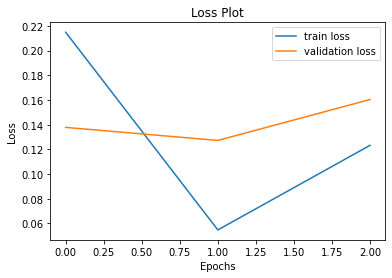

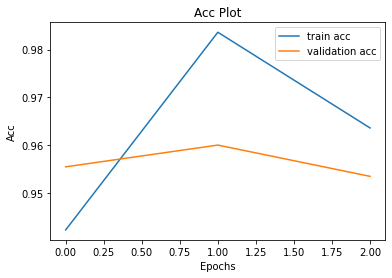

01:21:51.16
expected= ['e4', 'e5', 'Nf3', 'Nc6', '<end>']
predicted= ['e4', 'e5']
/content/dataset-v035--2lines-32k-v5.0/train/images/e4__e5__Nf3_Nc6_0868_4120_L_part5_scan0064.jpg


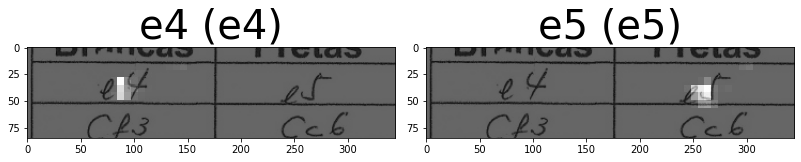

expected= ['Bb3', 'dxc5', 'Nbd7', 'Bxd7+', '<end>']
predicted= ['Bb3', 'dxc5']
/content/dataset-v035--2lines-32k-v5.0/valid/images/new-random_2f95295e.jpg


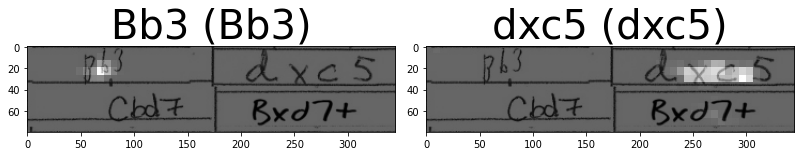

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


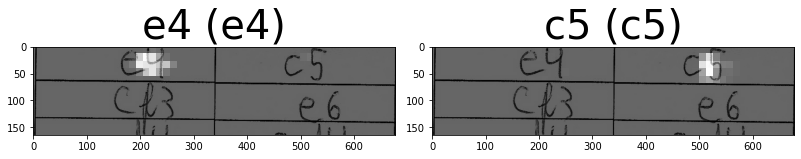

------------------------ 1 ------------------------------
predicted ['e4', 'c5']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


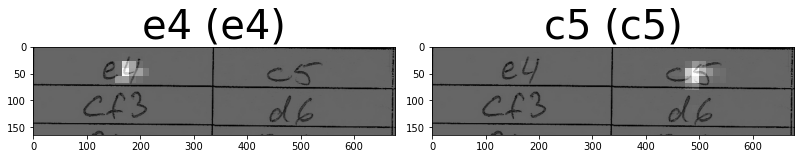

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


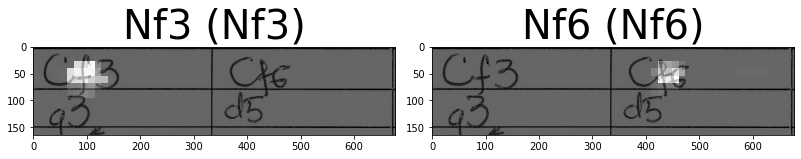

------------------------ 3 ------------------------------
predicted ['c4', 'c5']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


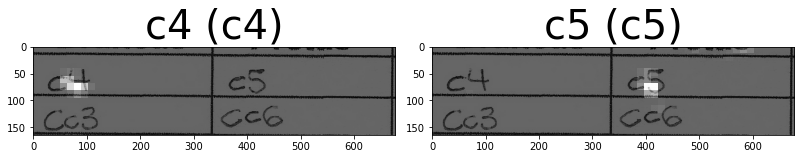

------------------------ 4 ------------------------------
predicted ['d4', 'd5']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


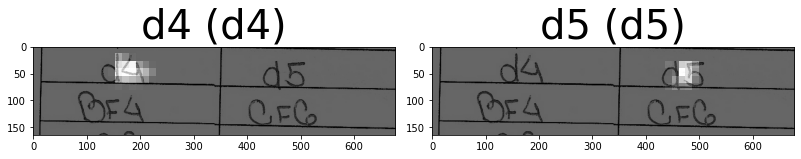

evaluating  100 ...
len 1 accuracy 0.8421052694320679 cir 0.0877193
len 2 accuracy 0.7675438523292542 cir 0.15277779


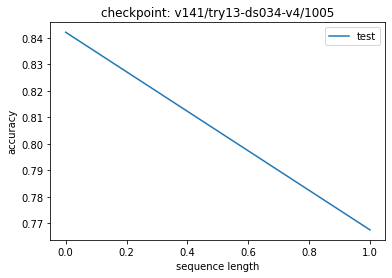

iniciando para lengh 2  target 0.1
len= 2  try_count= 0
-- loss_target=> 0.1  train_length= 2
Epoch 4 Batch 0 Loss 0.0464
Epoch 4 Batch 50 Loss 0.0081
Epoch 4 Batch 100 Loss 0.1270
Epoch 4 Batch 150 Loss 0.0352
Epoch 4 Batch 200 Loss 0.0159
Epoch 4 Batch 250 Loss 0.0257
Epoch 4 Batch 300 Loss 0.0748
Epoch 4 Batch 350 Loss 0.0097
Epoch 4 Batch 400 Loss 0.1568
Epoch 4 Batch 450 Loss 0.0200
Epoch 4 Batch 500 Loss 0.0075
Epoch 4 Batch 550 Loss 0.0283
Epoch 4 Batch 600 Loss 0.0031
Epoch 4 Batch 650 Loss 0.0278
Epoch 4 Loss 0.044147  acc: 0.9856 [ Validation Loss 0.143613 valid_acc: 0.9625 ]
Time taken for 1 epoch 1191.3092708587646 sec

01:44:47.93
Target reached! stop!  len=  2
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1005/checkpoints/train/ckpt-36


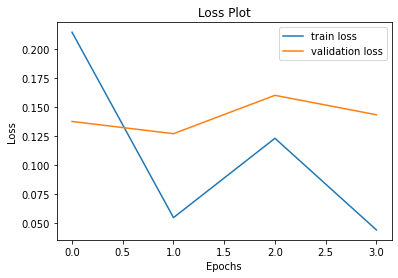

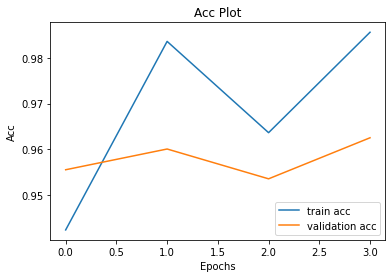

01:44:48.54
expected= ['e4', 'e5', 'Nf3', 'Nc6', '<end>']
predicted= ['e4', 'e5']
/content/dataset-v035--2lines-32k-v5.0/train/images/e4__e5__Nf3_Nc6_0868_4120_L_part5_scan0064.jpg


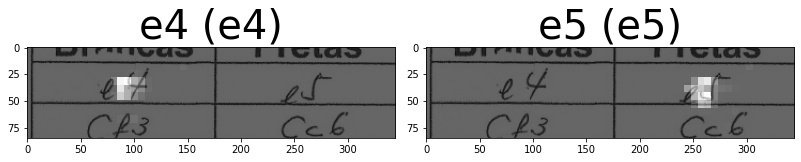

expected= ['Bb3', 'dxc5', 'Nbd7', 'Bxd7+', '<end>']
predicted= ['Bb3', 'dxc5']
/content/dataset-v035--2lines-32k-v5.0/valid/images/new-random_2f95295e.jpg


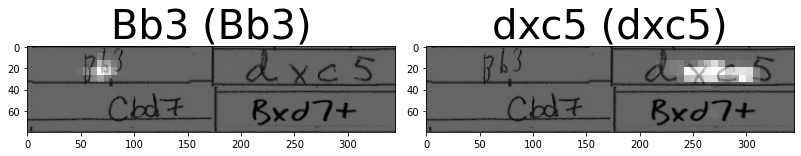

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


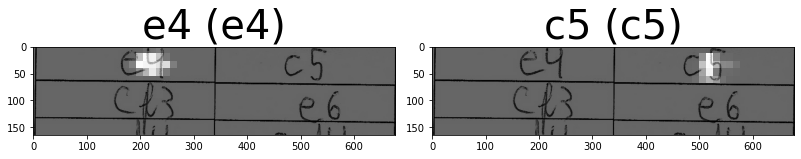

------------------------ 1 ------------------------------
predicted ['e4', 'e5']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


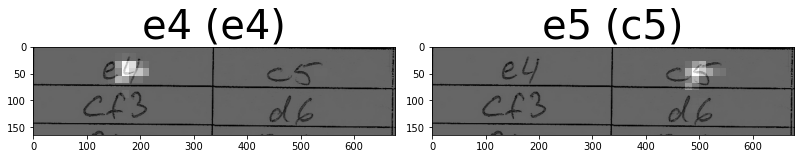

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


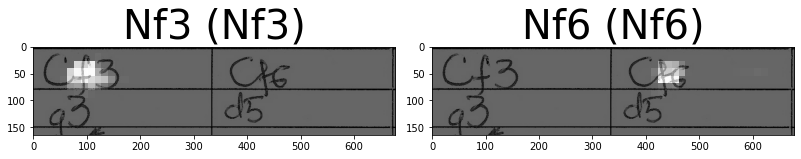

------------------------ 3 ------------------------------
predicted ['c4', 'c5']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


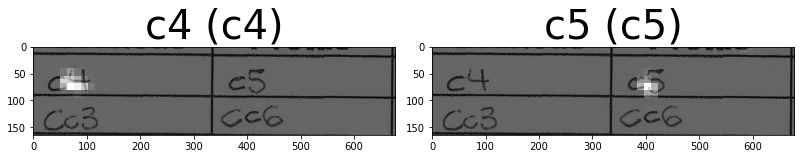

------------------------ 4 ------------------------------
predicted ['d4', 'd5']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


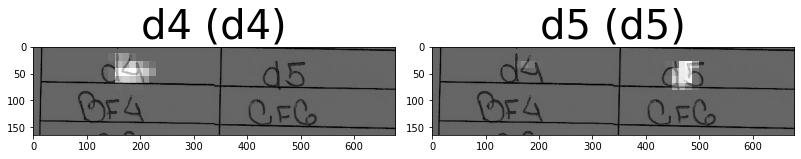

evaluating  100 ...
len 1 accuracy 0.8157894611358643 cir 0.09941521
len 2 accuracy 0.7938596606254578 cir 0.12061404


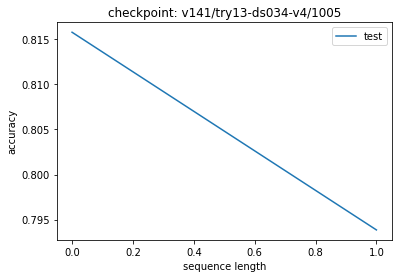

iniciando para lengh 3  target 0.25
len= 3  try_count= 0
-- loss_target=> 0.25  train_length= 3
Epoch 5 Batch 0 Loss 0.1903
Epoch 5 Batch 50 Loss 0.0416
Epoch 5 Batch 100 Loss 0.0880
Epoch 5 Batch 150 Loss 0.0200
Epoch 5 Batch 200 Loss 0.0166
Epoch 5 Batch 250 Loss 0.0392
Epoch 5 Batch 300 Loss 0.1319
Epoch 5 Batch 350 Loss 0.0420
Epoch 5 Batch 400 Loss 0.0782
Epoch 5 Batch 450 Loss 0.0491
Epoch 5 Batch 500 Loss 0.0454
Epoch 5 Batch 550 Loss 0.0751
Epoch 5 Batch 600 Loss 0.0371
Epoch 5 Batch 650 Loss 0.0988
Epoch 5 Loss 0.093150  acc: 0.9715 [ Validation Loss 0.159750 valid_acc: 0.9569 ]
Time taken for 1 epoch 1206.9395458698273 sec

02:08:00.65
Target reached! stop!  len=  3
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1005/checkpoints/train/ckpt-37


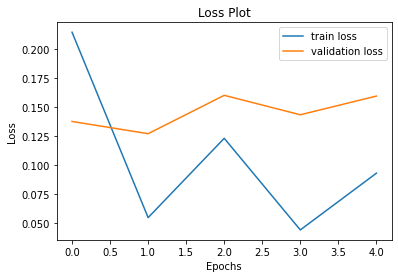

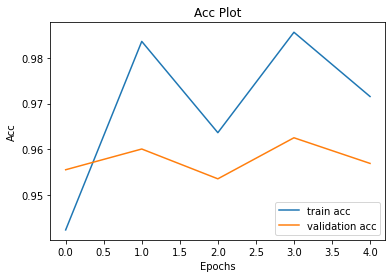

02:08:01.26
expected= ['e4', 'e5', 'Nf3', 'Nc6', '<end>']
predicted= ['e4', 'e5', 'Nf3']
/content/dataset-v035--2lines-32k-v5.0/train/images/e4__e5__Nf3_Nc6_0868_4120_L_part5_scan0064.jpg


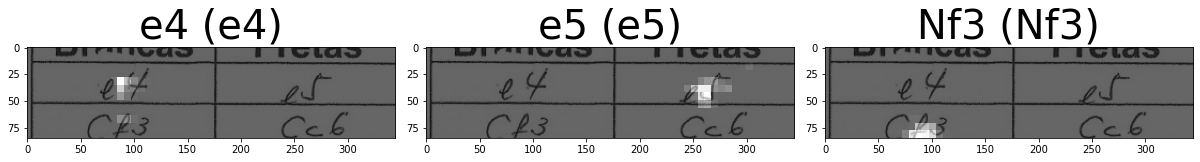

expected= ['Bb3', 'dxc5', 'Nbd7', 'Bxd7+', '<end>']
predicted= ['Bb3', 'dxc5', 'Nbd7']
/content/dataset-v035--2lines-32k-v5.0/valid/images/new-random_2f95295e.jpg


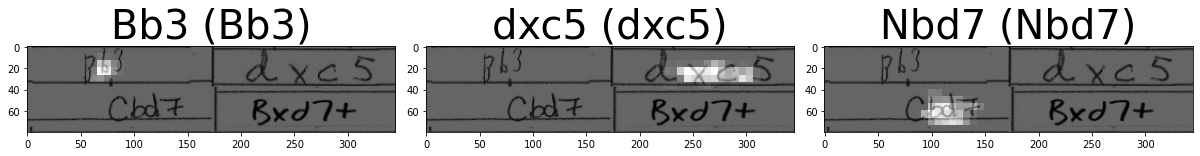

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5', 'Nf3']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


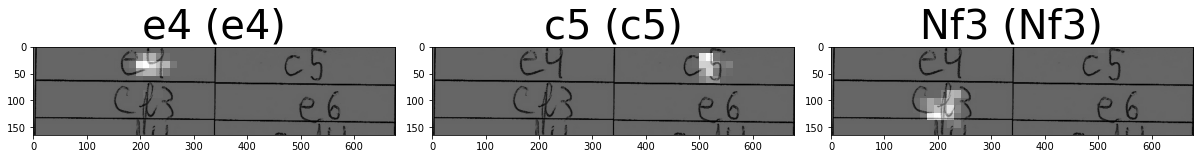

------------------------ 1 ------------------------------
predicted ['e4', 'c5', 'Nf3']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


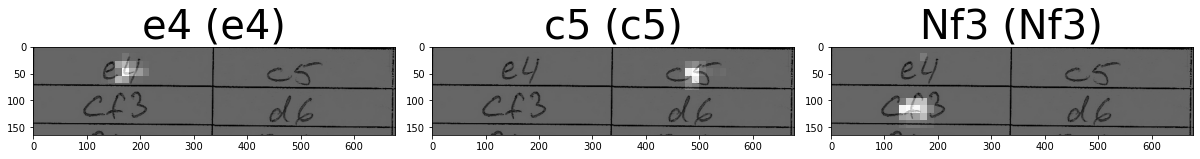

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6', 'g3']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


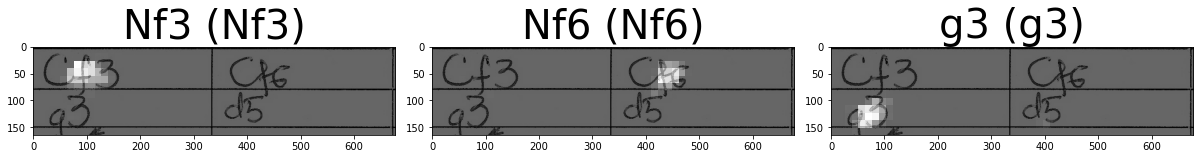

------------------------ 3 ------------------------------
predicted ['c4', 'e5', 'Nc3']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


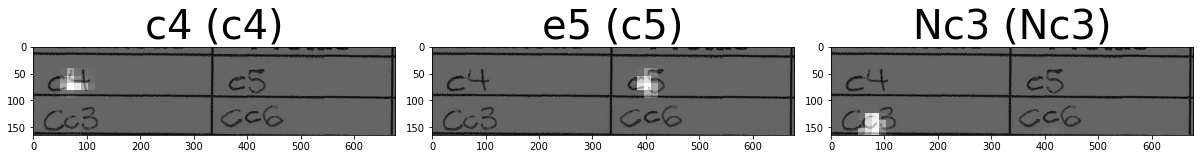

------------------------ 4 ------------------------------
predicted ['d4', 'd5', 'Bf4']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


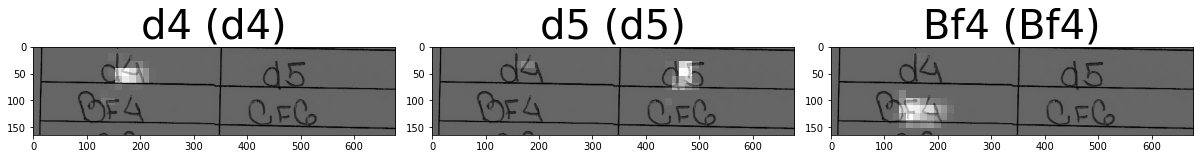

evaluating  100 ...
len 1 accuracy 0.859649121761322 cir 0.07309942
len 2 accuracy 0.7763158082962036 cir 0.13084796
len 3 accuracy 0.8040935397148132 cir 0.11427876


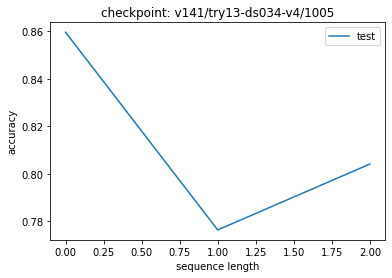

iniciando para lengh 3  target 0.1
len= 3  try_count= 0
-- loss_target=> 0.1  train_length= 3
Epoch 6 Batch 0 Loss 0.0365
Epoch 6 Batch 50 Loss 0.0468
Epoch 6 Batch 100 Loss 0.0129
Epoch 6 Batch 150 Loss 0.0060
Epoch 6 Batch 200 Loss 0.0165
Epoch 6 Batch 250 Loss 0.0228
Epoch 6 Batch 300 Loss 0.0376
Epoch 6 Batch 350 Loss 0.0587
Epoch 6 Batch 400 Loss 0.0765
Epoch 6 Batch 450 Loss 0.0817
Epoch 6 Batch 500 Loss 0.0180
Epoch 6 Batch 550 Loss 0.0805
Epoch 6 Batch 600 Loss 0.0280
Epoch 6 Batch 650 Loss 0.0856
Epoch 6 Loss 0.035133  acc: 0.9885 [ Validation Loss 0.140080 valid_acc: 0.9640 ]
Time taken for 1 epoch 1189.0711088180542 sec

02:30:59.29
Target reached! stop!  len=  3
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1005/checkpoints/train/ckpt-38


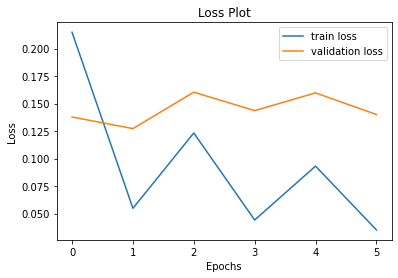

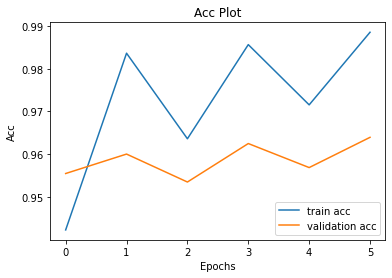

02:30:59.89
expected= ['e4', 'e5', 'Nf3', 'Nc6', '<end>']
predicted= ['e4', 'e5', 'Nf3']
/content/dataset-v035--2lines-32k-v5.0/train/images/e4__e5__Nf3_Nc6_0868_4120_L_part5_scan0064.jpg


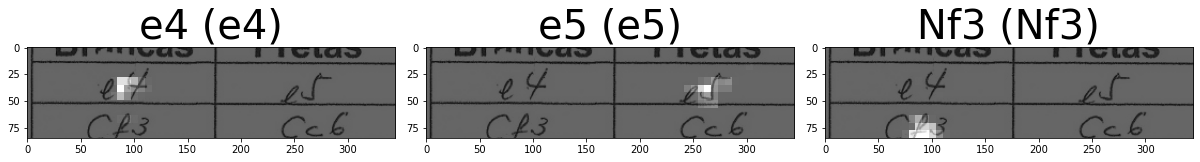

expected= ['Bb3', 'dxc5', 'Nbd7', 'Bxd7+', '<end>']
predicted= ['Bb3', 'dxc5', 'Nbd7']
/content/dataset-v035--2lines-32k-v5.0/valid/images/new-random_2f95295e.jpg


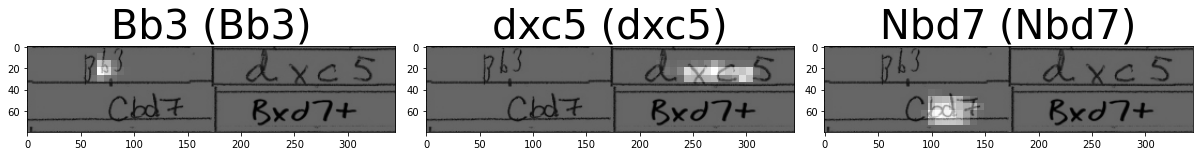

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5', 'Nf3']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


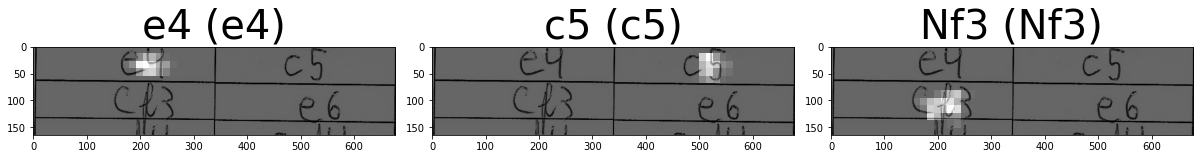

------------------------ 1 ------------------------------
predicted ['e4', 'c5', 'Nf3']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


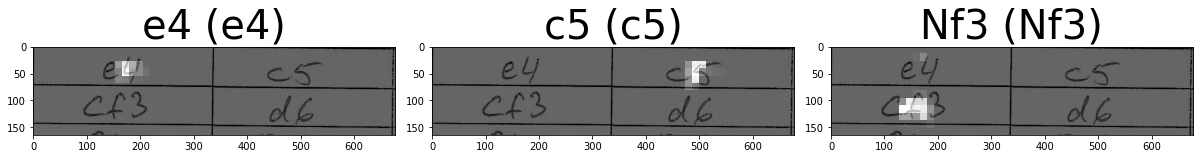

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6', 'g3']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


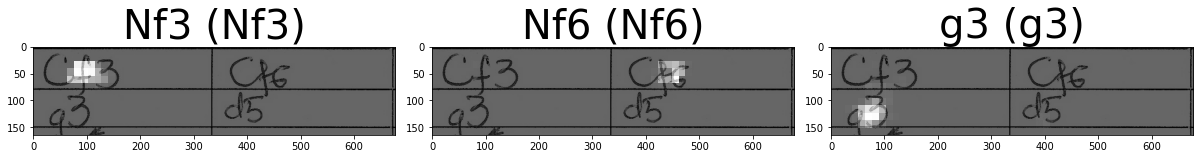

------------------------ 3 ------------------------------
predicted ['c4', 'c3', 'Nc3']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


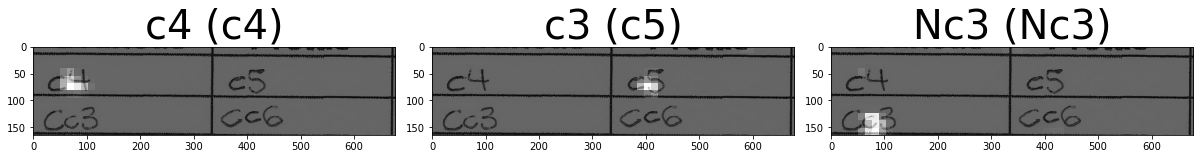

------------------------ 4 ------------------------------
predicted ['d4', 'd5', 'f4']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


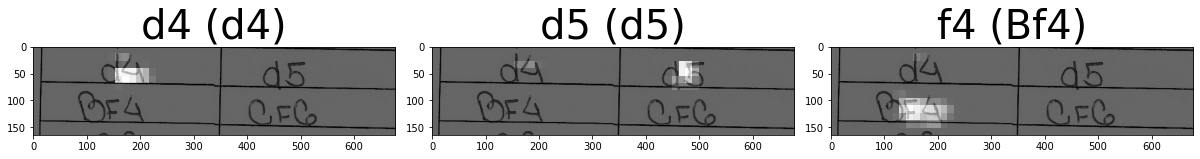

evaluating  100 ...
len 1 accuracy 0.8684210777282715 cir 0.06871345
len 2 accuracy 0.8289473652839661 cir 0.10307018
len 3 accuracy 0.8450292348861694 cir 0.09259259


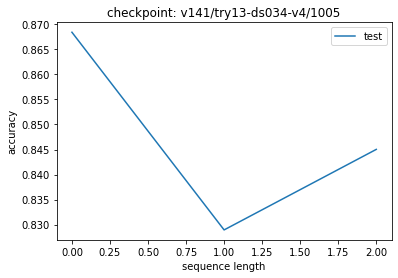

iniciando para lengh 4  target 0.25
len= 4  try_count= 0
-- loss_target=> 0.25  train_length= 4
Epoch 7 Batch 0 Loss 1.8909
Epoch 7 Batch 50 Loss 0.1144
Epoch 7 Batch 100 Loss 0.0409
Epoch 7 Batch 150 Loss 0.0149
Epoch 7 Batch 200 Loss 0.1105
Epoch 7 Batch 250 Loss 0.1423
Epoch 7 Batch 300 Loss 0.0753
Epoch 7 Batch 350 Loss 0.0620
Epoch 7 Batch 400 Loss 0.0540
Epoch 7 Batch 450 Loss 0.2410
Epoch 7 Batch 500 Loss 0.0839
Epoch 7 Batch 550 Loss 0.0352
Epoch 7 Batch 600 Loss 0.0668
Epoch 7 Batch 650 Loss 0.0558
Epoch 7 Loss 0.085536  acc: 0.9742 [ Validation Loss 0.150542 valid_acc: 0.9586 ]
Time taken for 1 epoch 1196.0813579559326 sec

02:54:03.18
Target reached! stop!  len=  4
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1005/checkpoints/train/ckpt-39


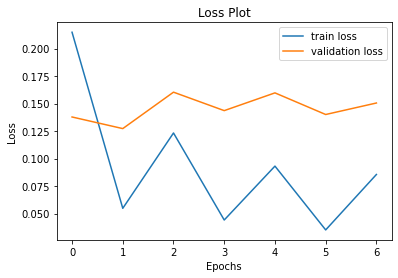

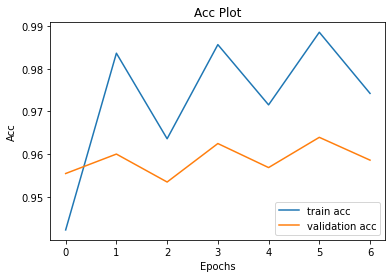

02:54:03.79
expected= ['e4', 'e5', 'Nf3', 'Nc6', '<end>']
predicted= ['e4', 'e5', 'Nf3', 'Nc6']
/content/dataset-v035--2lines-32k-v5.0/train/images/e4__e5__Nf3_Nc6_0868_4120_L_part5_scan0064.jpg


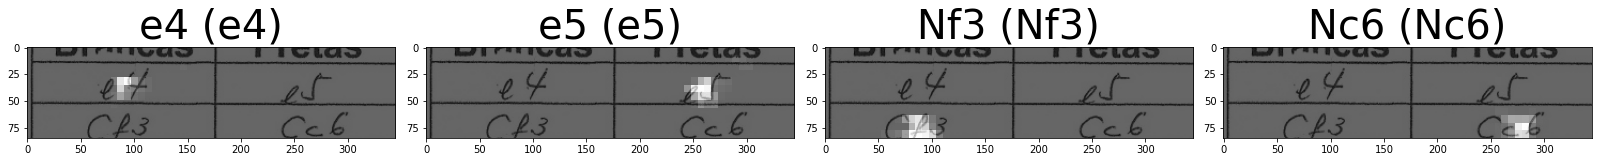

expected= ['Bb3', 'dxc5', 'Nbd7', 'Bxd7+', '<end>']
predicted= ['Bb3', 'dxc5', 'Nbd7', 'Bxd7+']
/content/dataset-v035--2lines-32k-v5.0/valid/images/new-random_2f95295e.jpg


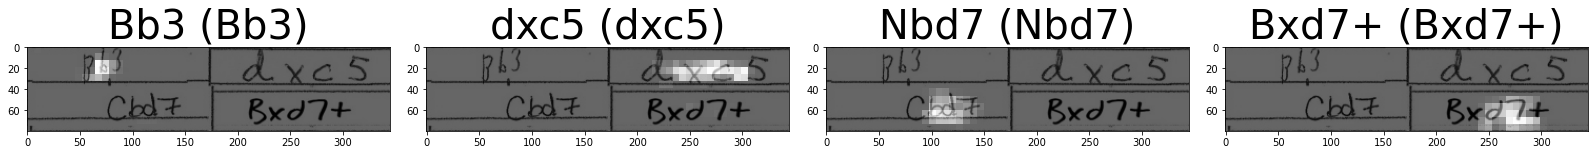

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5', 'Nf3', 'g6']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


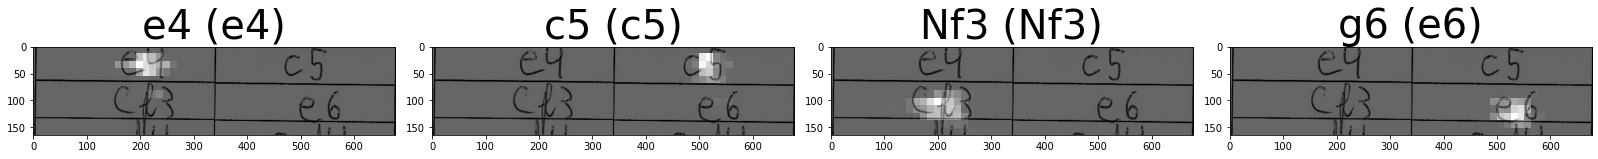

------------------------ 1 ------------------------------
predicted ['e4', 'c6', 'Nf3', 'd6']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


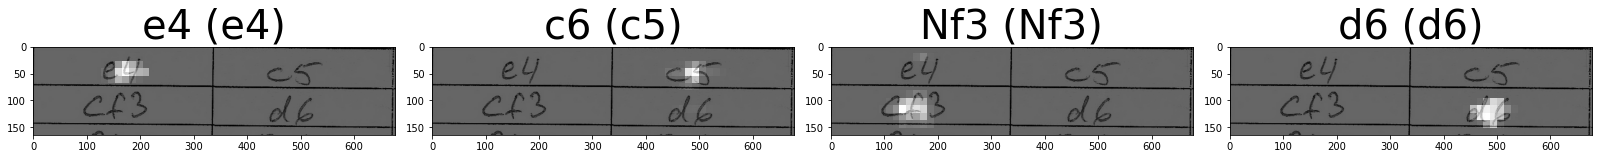

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6', 'g3', 'd5']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


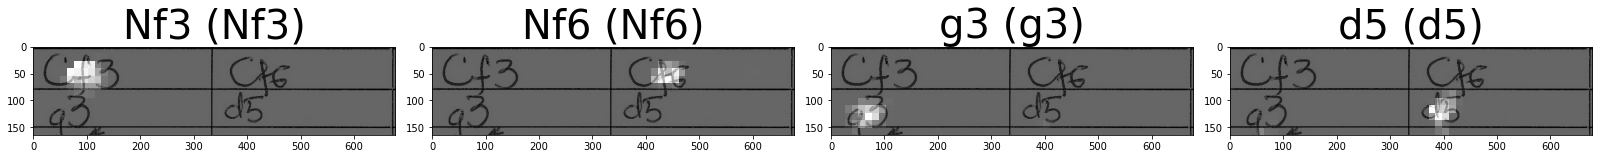

------------------------ 3 ------------------------------
predicted ['c4', 'e5', 'Nc3', 'e6']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


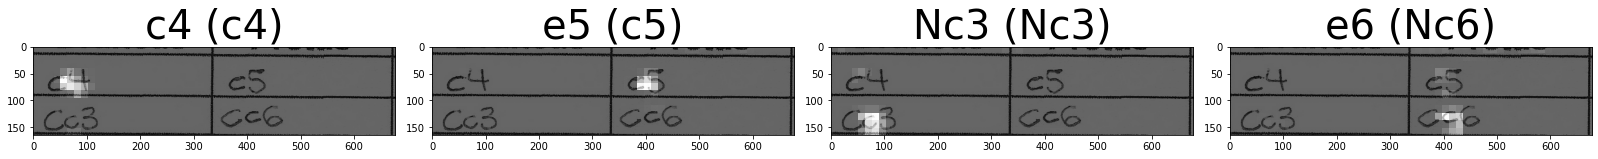

------------------------ 4 ------------------------------
predicted ['d4', 'd5', 'Bf4', 'Nf6']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


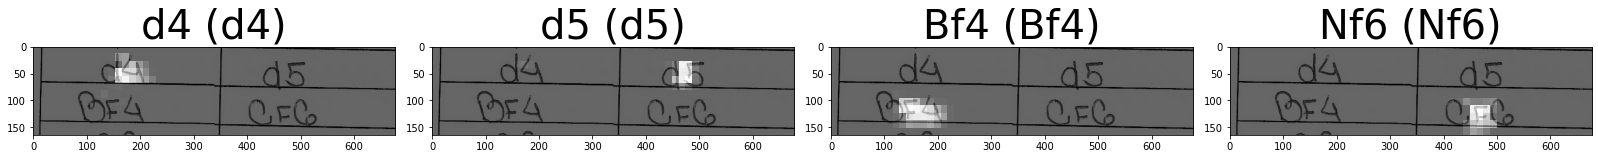

evaluating  100 ...
len 1 accuracy 0.7982456088066101 cir 0.10526316
len 2 accuracy 0.7894737124443054 cir 0.118421055
len 3 accuracy 0.8216374516487122 cir 0.10282651
len 4 accuracy 0.8157894611358643 cir 0.10475147


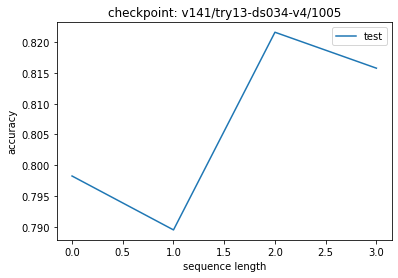

iniciando para lengh 4  target 0.1
len= 4  try_count= 0
-- loss_target=> 0.1  train_length= 4
Epoch 8 Batch 0 Loss 0.0979
Epoch 8 Batch 50 Loss 0.0454
Epoch 8 Batch 100 Loss 0.0927
Epoch 8 Batch 150 Loss 0.0159
Epoch 8 Batch 200 Loss 0.0206
Epoch 8 Batch 250 Loss 0.0095
Epoch 8 Batch 300 Loss 0.0282
Epoch 8 Batch 350 Loss 0.0280
Epoch 8 Batch 400 Loss 0.0083
Epoch 8 Batch 450 Loss 0.0057
Epoch 8 Batch 500 Loss 0.0383
Epoch 8 Batch 550 Loss 0.0214
Epoch 8 Batch 600 Loss 0.0355
Epoch 8 Batch 650 Loss 0.0922
Epoch 8 Loss 0.032454  acc: 0.9890 [ Validation Loss 0.151924 valid_acc: 0.9628 ]
Time taken for 1 epoch 1187.3296558856964 sec

03:17:01.50
Target reached! stop!  len=  4
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1005/checkpoints/train/ckpt-40


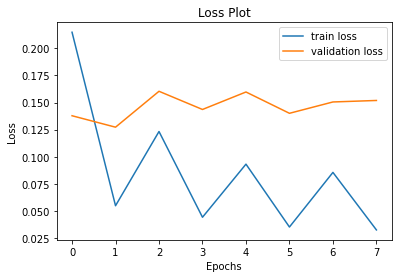

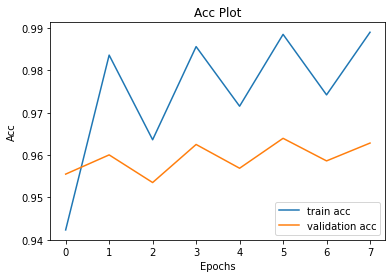

03:17:02.12
expected= ['e4', 'e5', 'Nf3', 'Nc6', '<end>']
predicted= ['e4', 'e5', 'Nf3', 'Nc6']
/content/dataset-v035--2lines-32k-v5.0/train/images/e4__e5__Nf3_Nc6_0868_4120_L_part5_scan0064.jpg


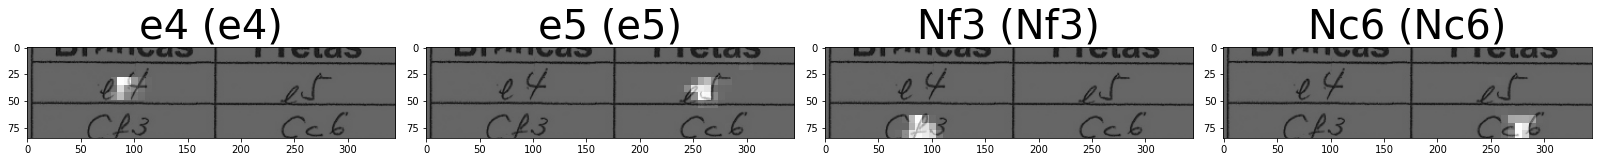

expected= ['Bb3', 'dxc5', 'Nbd7', 'Bxd7+', '<end>']
predicted= ['Bb3', 'dxc5', 'Nbd7', 'Bxd7+']
/content/dataset-v035--2lines-32k-v5.0/valid/images/new-random_2f95295e.jpg


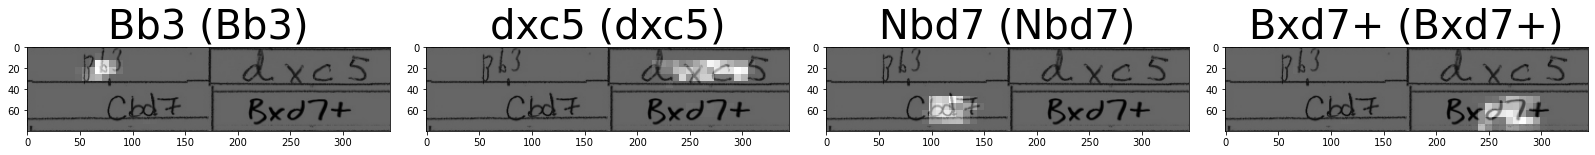

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5', 'Nf3', 'e6']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


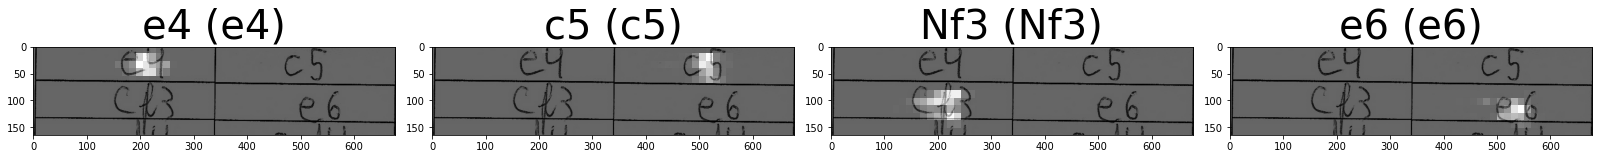

------------------------ 1 ------------------------------
predicted ['e4', 'c5', 'Nf3', 'd6']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


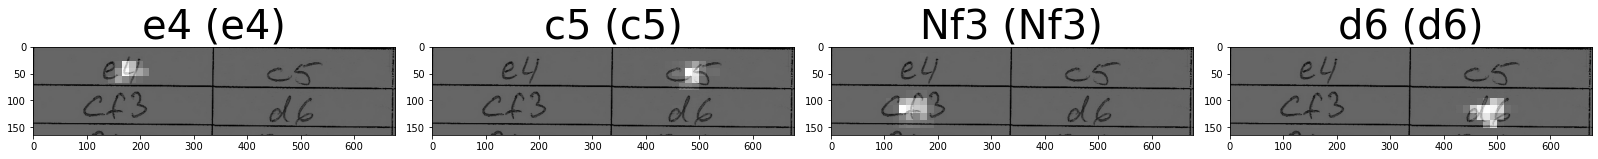

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6', 'g3', 'd5']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


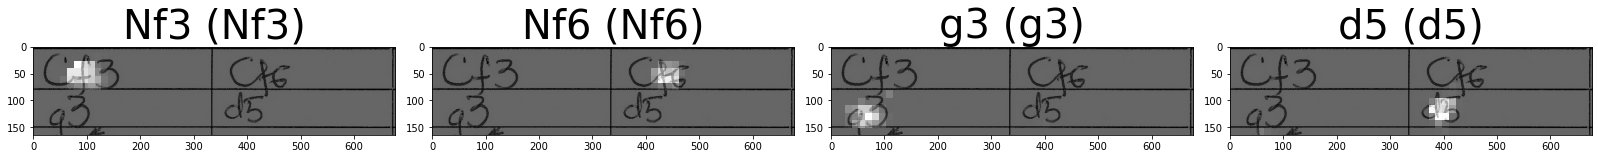

------------------------ 3 ------------------------------
predicted ['c4', 'e5', 'Nc3', 'Nc6']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


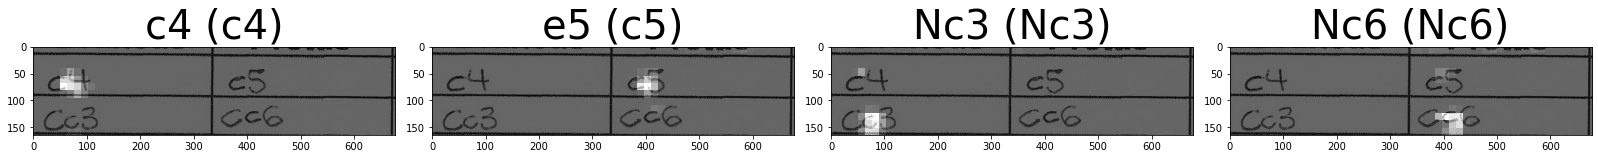

------------------------ 4 ------------------------------
predicted ['d4', 'd5', 'Bf4', 'e6']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


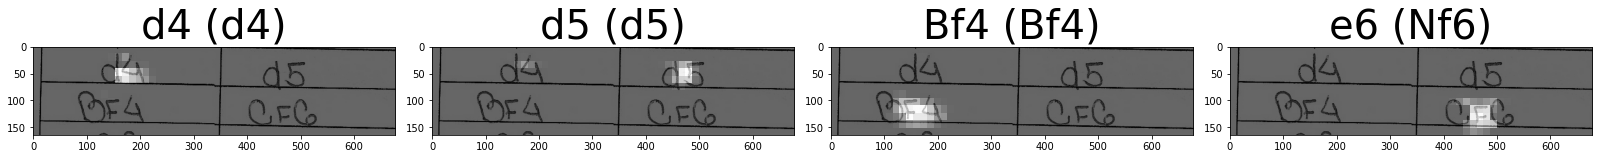

evaluating  100 ...
len 1 accuracy 0.8684210777282715 cir 0.07017544
len 2 accuracy 0.8157894611358643 cir 0.10964912
len 3 accuracy 0.8333333134651184 cir 0.10185186
len 4 accuracy 0.8157894611358643 cir 0.11239036


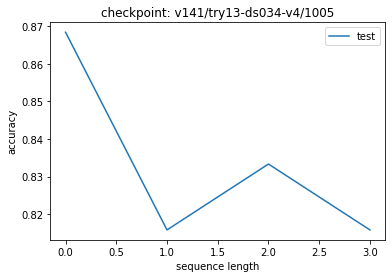

In [ ]:
for _len in [1,2,3,4]:
  for _target in [0.25,0.1]:
    print( 'iniciando para lengh', _len, ' target', _target)
    if not train_more_with_retry( _target, _len, 2000):
      print( 'numero de tentativas excedido sem sucesso. Abort')
      assert False

    print_time()    
    try:
      evaluate_train(1, _len)
      evaluate_valid(1, _len)
      make_evaluations_test_set(_len)
    except Exception as e:
      print( 'oops error..', e)